# Kalman filter and Hungarian algorithm as assignment method

In [77]:
import cv2
import numpy as np
from scipy.optimize import linear_sum_assignment

class KalmanFilter:
    def __init__(self):
        self.kf = cv2.KalmanFilter(4, 2)
        self.kf.measurementMatrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], np.float32)
        self.kf.transitionMatrix = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], np.float32)
        self.kf.processNoiseCov = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]], np.float32) * 0.03

    def predict(self):
        return self.kf.predict()

    def correct(self, coordX, coordY):
        measurement = np.array([[np.float32(coordX)], [np.float32(coordY)]])
        self.kf.correct(measurement)

def track_dots(video_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    positions = []
    next_id = 0
    prev_positions = {}
    kalman_filters = {}
    line_position = 800  # Define the horizontal line position
    cross_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = frame[525:1128, 400:1500]

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 170, 255, cv2.THRESH_BINARY_INV)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        current_positions = {}
        centroids = []
        for contour in contours:
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                centroids.append((cx, cy))

        if prev_positions:
            predicted_positions = {}
            for dot_id, kf in kalman_filters.items():
                predicted = kf.predict()
                predicted_positions[dot_id] = (predicted[0], predicted[1])

            cost_matrix = np.zeros((len(predicted_positions), len(centroids)))
            prev_ids = list(predicted_positions.keys())

            for i, prev_id in enumerate(prev_ids):
                for j, centroid in enumerate(centroids):
                    cost_matrix[i, j] = np.linalg.norm(np.array(predicted_positions[prev_id]) - np.array(centroid))

            row_ind, col_ind = linear_sum_assignment(cost_matrix)

            assigned_centroids = set()
            for i, j in zip(row_ind, col_ind):
                current_positions[prev_ids[i]] = centroids[j]
                kalman_filters[prev_ids[i]].correct(centroids[j][0], centroids[j][1])
                assigned_centroids.add(j)

            for j, centroid in enumerate(centroids):
                if j not in assigned_centroids:
                    current_positions[next_id] = centroid
                    kalman_filters[next_id] = KalmanFilter()
                    kalman_filters[next_id].correct(centroid[0], centroid[1])
                    next_id += 1
        else:
            for centroid in centroids:
                current_positions[next_id] = centroid
                kalman_filters[next_id] = KalmanFilter()
                kalman_filters[next_id].correct(centroid[0], centroid[1])
                next_id += 1

        positions.append(current_positions)
        prev_positions = current_positions

        for dot_id, (cx, cy) in current_positions.items():
            if cx > line_position and prev_positions[dot_id][0] <= line_position:
                cross_count += 1
            cv2.circle(frame, (cx, cy), 5, (0, 0, 255), -1)
            cv2.putText(frame, str(dot_id), (cx + 5, cy - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

        cv2.line(frame, (line_position, 0), (line_position, frame.shape[0]), (255, 0, 0), 2)
        cv2.putText(frame, f'Cross Count: {cross_count}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.imshow('Tracking', frame)
        if cv2.waitKey(int((1/fps)*1000*10)) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    return positions

# Example usage:
video_path = "241220_J10_DicerII_Chloe.avi"
positions = track_dots(video_path)

KeyboardInterrupt: 

# Automated performance index

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import tools as tl

In [2]:
fps = 10 # sampling rate
data_folder='//iss/corti-corvol/share/tests-locomoteur'
meta=pd.read_csv('video_metadata_AZ.csv')
meta['genotype'] = meta['genotype'].apply(lambda s: s.replace(" ", "-").strip("-"))
meta=meta[meta['genotype']!='empty']
meta=meta.groupby(['genotype', 'timepoint'])

In [3]:
# Iterate over each unique combination and print the subset
columns = {
    "1": (154, 517, 135, 610),
    "2": (352, 517, 135, 610),
    "3": (572, 517, 135, 610),
    "4": (792, 517, 135, 610),
    "5": (1000, 517, 135, 610),
    "6": (1210, 517, 135, 610),
    "7": (1430, 517, 135, 610),
    "8": (1628, 517, 135, 610)
}

result = {}

for (genotype, time_point), subset in meta:

    performance = []
    
    for __, row in subset.iterrows():
        # set the video path
        video_path = data_folder+'/'+row['video_name'].split('_')[0]+'/'+row['video_name']+'.avi'

        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Error: Cannot open video file {video_path}")
            exit()

        counts = []
        total = []

        while cap.isOpened():
            ret, frame = cap.read()
            
            if not ret or frame is None:
                print("Error: Frame not read correctly")
                break

            height, width = frame.shape[:2]  # Get frame dimensions

            combined_frame = None
            (x,y,w,h) = columns[str(row['column'])] # get the right vial
            if x < 0 or y < 0 or x + w > width or y + h > height:
                print(f"Skipping invalid tube (Out of bounds)")
                continue

            # Correct slicing order: frame[y:y+h, x:x+w]
            framecrop = frame[y:y+h, x:x+w]

            if framecrop.size == 0:
                print(f"Skipping empty crop")
                continue

            gray = cv2.cvtColor(framecrop, cv2.COLOR_BGR2GRAY)
            _, thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV)
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            centroids = []
            for contour in contours:
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])
                    centroids.append((cx, cy))
                    # Draw red dot on the centroid
                    cv2.circle(framecrop, (cx, cy), 5, (0, 0, 255), -1)

            line_position = h // 2  
            counts.append(sum(1 for _, cy in centroids if line_position - 10 <= cy <= line_position + 10))
            total.append(len(contours))

            # Combine the frames side by side
            #if combined_frame is None:
            #    combined_frame = framecrop
            #else:
            #    combined_frame = np.hstack((combined_frame, framecrop))

        #if combined_frame is not None:
        #    cv2.imshow("Combined ROIs", combined_frame)

        #if cv2.waitKey(int((1 / fps) * 1000)) & 0xFF == ord('q'):
        #    break

        cap.release()
        cv2.destroyAllWindows()

        counts = np.transpose(np.array(counts).reshape(-1, 5))
        total =np.transpose(np.array(total).reshape(-1, 5))
        performance.append([counts,total])

    result[(genotype, time_point)] = performance  

Error: Frame not read correctly
Error: Frame not read correctly
Error: Frame not read correctly
Error: Frame not read correctly
Error: Frame not read correctly
Error: Frame not read correctly
Error: Frame not read correctly
Error: Frame not read correctly
Error: Frame not read correctly
Error: Frame not read correctly
Error: Frame not read correctly
Error: Frame not read correctly
Error: Frame not read correctly
Error: Frame not read correctly
Error: Frame not read correctly
Error: Frame not read correctly
Error: Frame not read correctly
Error: Frame not read correctly
Error: Frame not read correctly
Error: Frame not read correctly
Error: Frame not read correctly
Error: Frame not read correctly
Error: Frame not read correctly
Error: Frame not read correctly
Error: Frame not read correctly
Error: Frame not read correctly
Error: Frame not read correctly
Error: Frame not read correctly
Error: Frame not read correctly
Error: Frame not read correctly
Error: Frame not read correctly
Error: F

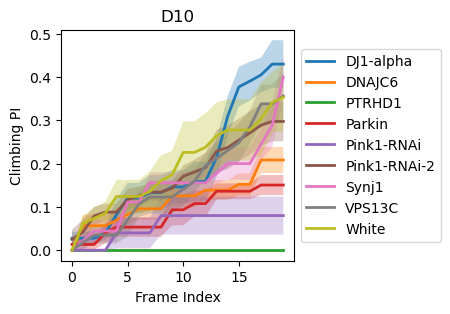

In [ ]:
KS = {}
plt.figure(figsize=(4, 3))
for key, value in result.items():
    if key[1] == 'D10':
        counts = value[0][0]
        total = value[0][1]
        
        PI = []
        # Compute the cumulative sum and normalize by the max value of each row
        #
        for i, count in enumerate(counts):
            if np.cumsum(count)[-1]>np.max(total[i]):
                cdf = np.cumsum(count)/np.cumsum(count)[-1]
            else:
                cdf = np.cumsum(count)/np.max(total[i])
            PI.append(cdf)
        PI = np.array(PI)

        mean_PI = np.nanmean(PI, axis=0)
        KS[key[0]] = mean_PI
        sem_PI = np.std(PI, axis=0) / np.sqrt(PI.shape[0])
        
        # Plot the mean PI and the SEM shading
        plt.plot(mean_PI, label=f'{key[0]}', linewidth=2)  # Using the key for the legend
        plt.fill_between(np.arange(len(mean_PI)), mean_PI - sem_PI, mean_PI + sem_PI, alpha=0.3)

# Add the legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Labels and title
plt.xlabel('Frame Index')
plt.ylabel('Climbing PI')
plt.title('D10')
# Show the plot
plt.show()

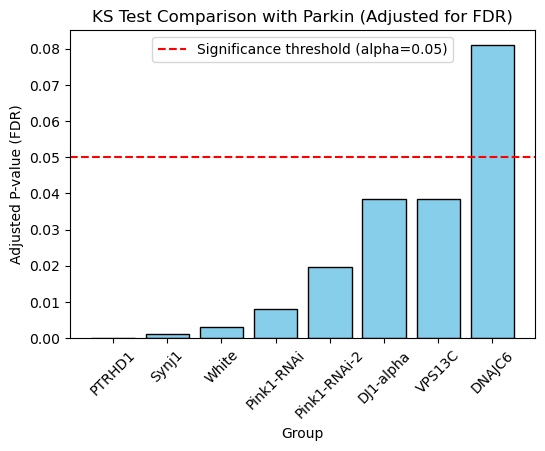

Group: PTRHD1, Adjusted p-value: 1.1607111283079745e-10
  - Significant (p < 0.05)
Group: Synj1, Adjusted p-value: 0.0010819893781638709
  - Significant (p < 0.05)
Group: White, Adjusted p-value: 0.0029754707899506453
  - Significant (p < 0.05)
Group: Pink1-RNAi, Adjusted p-value: 0.00793458877320172
  - Significant (p < 0.05)
Group: Pink1-RNAi-2, Adjusted p-value: 0.019677780134326046
  - Significant (p < 0.05)
Group: DJ1-alpha, Adjusted p-value: 0.038333325035596
  - Significant (p < 0.05)
Group: VPS13C, Adjusted p-value: 0.038333325035596
  - Significant (p < 0.05)
Group: DNAJC6, Adjusted p-value: 0.08105771161340149


In [13]:
import numpy as np
from scipy.stats import ks_2samp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt

ref_genotype = 'Parkin'
# 1. Extract time series data for 'White'
reference = KS[ref_genotype]

# 2. Perform KS test for each group against 'White'
p_values = []
group_names = []

for key, value in KS.items():
    if key != ref_genotype:
        # Perform KS test comparing 'White' with the current group
        ks_statistic, p_value = ks_2samp(reference, value)
        p_values.append(p_value)
        group_names.append(key)

# 3. Adjust for multiple testing using Benjamini-Hochberg (FDR)
adjusted_p_values = multipletests(p_values, method='fdr_bh')[1]

# 4. Sort the results by adjusted p-values (increasing order)
sorted_indices = np.argsort(adjusted_p_values)
sorted_group_names = np.array(group_names)[sorted_indices]
sorted_adjusted_p_values = adjusted_p_values[sorted_indices]

# 5. Plot the results
plt.figure(figsize=(6, 4))
plt.bar(sorted_group_names, sorted_adjusted_p_values, color='skyblue', edgecolor='black')
plt.axhline(0.05, color='red', linestyle='--', label="Significance threshold (alpha=0.05)")
plt.xlabel('Group')
plt.ylabel('Adjusted P-value (FDR)')
plt.title('KS Test Comparison with Parkin (Adjusted for FDR)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5,1))
plt.xticks(rotation=45)
plt.show()

# 6. Print the results (you can filter to show significant comparisons)
for group, adj_p in zip(sorted_group_names, sorted_adjusted_p_values):
    print(f"Group: {group}, Adjusted p-value: {adj_p}")
    if adj_p < 0.05:
        print(f"  - Significant (p < 0.05)")
